In [1]:
import os

import tensorflow as tf
print("TF:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))


I0000 00:00:1761805812.136205  100793 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1761805812.171981  100793 cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1761805812.917900  100793 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


TF: 2.21.0-dev20251017
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


W0000 00:00:1761805813.745361  100793 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.


In [2]:
#undersample

import os, random, shutil

# --- Paths ---
original_dir = "/home/lurpd/Development/Datasets/DistractedDriverSet/imgs/train"
balanced_dir = "/home/lurpd/Development/Datasets/DistractedDriverSet/imgs/train_balanced"

# --- Clean previous balanced directory (if exists) ---
if os.path.exists(balanced_dir):
    shutil.rmtree(balanced_dir)
os.makedirs(balanced_dir, exist_ok=True)

# --- Count images in each class ---
class_counts = {}
for cls in os.listdir(original_dir):
    cls_path = os.path.join(original_dir, cls)
    if os.path.isdir(cls_path):
        images = [f for f in os.listdir(cls_path)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png')) and not f.startswith('.')]
        class_counts[cls] = len(images)

print("Class counts:", class_counts)

# --- Find the smallest class size ---
target = min(class_counts.values())
print(f"\nUndersampling all classes to {target} images each\n")

# --- Undersample each class ---
for cls, count in class_counts.items():
    src_folder = os.path.join(original_dir, cls)
    dst_folder = os.path.join(balanced_dir, cls)
    os.makedirs(dst_folder, exist_ok=True)

    # Get random subset of images equal to smallest class size
    files = [f for f in os.listdir(src_folder)
             if f.lower().endswith(('.jpg', '.jpeg', '.png')) and not f.startswith('.')]
    sampled_files = random.sample(files, target)

    # Create symlinks (lightweight, doesn’t duplicate files)
    for f in sampled_files:
        src = os.path.join(src_folder, f)
        dst = os.path.join(dst_folder, f)
        os.symlink(src, dst)

# --- Verify counts ---
for cls in os.listdir(balanced_dir):
    c = len(os.listdir(os.path.join(balanced_dir, cls)))
    print(f"{cls}: {c} images")


Class counts: {'c2': 1478, 'c1': 25261, 'c0': 4338}

Undersampling all classes to 1478 images each

c2: 1478 images
c1: 1478 images
c0: 1478 images


In [3]:
#imports
import numpy as np
import pandas as pd
import os 
from PIL import Image
import matplotlib.pyplot as plt

import random
import tensorflow as tf
from keras.models import Sequential
from keras.layers import MaxPooling2D,Conv2D,Dense,Dropout,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

In [4]:
#directories
base_dir = '' 
train_dir = "/home/lurpd/Development/Datasets/DistractedDriverSet/imgs/train_balanced"

In [ ]:
batch_size = 64
val_size = 0.2


MAX_SIZE = 128  #max height or width

def resize_keep_aspect(img):
    h, w = img.shape[:2]
    scale = MAX_SIZE / max(h, w)
    if scale < 1:
        new_w, new_h = int(w * scale), int(h * scale)
        img = tf.image.resize(img, (new_h, new_w), method='lanczos3')
    return img

train_data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    shear_range=0.15,
    brightness_range=[0.6, 1.4],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_data_gen = ImageDataGenerator(rescale=1./255,validation_split=0.2)

train_generator = train_data_gen.flow_from_directory(train_dir,
                                                     target_size = (MAX_SIZE, MAX_SIZE),
                                                     batch_size = batch_size,
                                                     seed=42, 
                                                     shuffle=True,
                                                     subset='training',
                                                     color_mode='grayscale',
                                                     class_mode='categorical'
                                                     )

val_generator = val_data_gen.flow_from_directory(
    train_dir,
    target_size=(MAX_SIZE, MAX_SIZE),
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    subset='validation',
    color_mode='grayscale',
    class_mode='categorical'
)

print("Detected classes:", train_generator.class_indices)


# #random data changes for better generalizing
# train_data_gen = ImageDataGenerator(
#     rescale=1./255,
#     validation_split=0.2,
#     preprocessing_function=resize_keep_aspect,
#     rotation_range=20,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.2,
#     brightness_range=[0.7, 1.3],
#     horizontal_flip=True
# )

# val_data_gen = ImageDataGenerator(
#     rescale=1./255,
#     validation_split=0.2,
#     preprocessing_function=resize_keep_aspect,
# )

# #training params
# train_generator = train_data_gen.flow_from_directory(
#     train_dir,
#     batch_size=batch_size,
#     seed=42,
#     shuffle=True,
#     subset='training',
#     color_mode='grayscale',
#     class_mode='categorical',
#     target_size=(MAX_SIZE, MAX_SIZE)
# )

# val_generator = val_data_gen.flow_from_directory(
#     train_dir,
#     target_size=(MAX_SIZE, MAX_SIZE),
#     batch_size=batch_size,
#     seed=42,
#     shuffle=False,
#     subset='validation',
#     color_mode='grayscale',
#     class_mode='categorical',
# )


Found 3549 images belonging to 3 classes.
Found 885 images belonging to 3 classes.
Detected classes: {'c0': 0, 'c1': 1, 'c2': 2}


In [6]:
#debug count data
import collections

class_counts = collections.Counter(train_generator.classes)
for cls, count in class_counts.items():
    print(f"{cls} ({list(train_generator.class_indices.keys())[cls]}): {count}")

0 (c0): 1183
1 (c1): 1183
2 (c2): 1183


(64, 128, 128, 1)
(64, 3)
(64, 128, 128, 1) 0.0 1.0


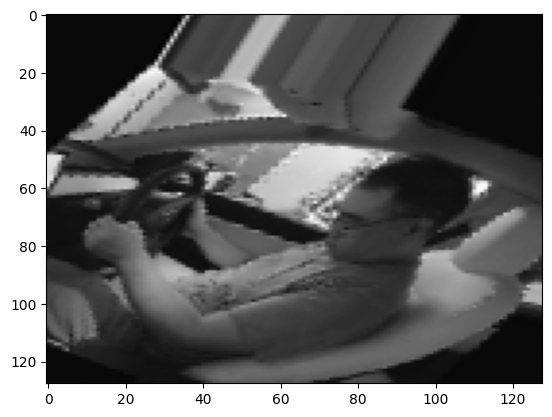

In [7]:
for data_batch,label_batch in train_generator:
    print(data_batch.shape) 
    print(label_batch.shape) 
    break

batch_x, batch_y = next(train_generator)
print(batch_x.shape, batch_x.min(), batch_x.max())
plt.imshow(np.squeeze(batch_x[0]), cmap='gray', aspect='auto')
plt.show()

In [8]:
#cpu handle random dropout cuz issue with CUDA
import tensorflow as tf
from keras.layers import Dropout

class CPUDropout(Dropout):
    def call(self, inputs, training=None):
        with tf.device('/CPU:0'):
            return super().call(inputs, training=training)


In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


model = Sequential([
    # Block 1
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(None, None, 1)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.05),

    # Block 2
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.1),

    # Block 3
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.2),

    # Block 4
    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    # Block 5
    Conv2D(512, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),

    # Classifier Head
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.summary() # to print summary of model architecture

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# #convert grayscale
# def to_rgb(x):
#     return tf.image.grayscale_to_rgb(x)

# #use mobilenet, transfer learning
# inputs = Input(shape=(None, None, 1)) 
# x = tf.keras.layers.Lambda(to_rgb)(inputs)
# base_model = MobileNetV2(
#     input_shape=(None, None, 3),
#     include_top=False,
#     weights='imagenet'
# )

# #unfreeze last 15 layers
# base_model.trainable = True
# for layer in base_model.layers[:-20]:
#     layer.trainable = False

# #custom classifier
# x = tf.keras.layers.Lambda(to_rgb)(inputs)
# x = base_model(x, training=False)
# x = GlobalAveragePooling2D()(x)
# x = Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(x)
# x = BatchNormalization()(x)
# x = Dropout(0.65)(x)
# x = Dense(128, activation='relu', kernel_regularizer=l2(0.0005))(x)
# x = Dropout(0.5)(x)
# outputs = Dense(train_generator.num_classes, activation='softmax')(x)

# model = Model(inputs, outputs)

# #yay
# model.compile(
#     optimizer=AdamW(learning_rate=5e-5, weight_decay=1e-4),
#     loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
#     metrics=['accuracy']
# )

# model.summary()


/home/lurpd/Development/DistractionAI/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1761805814.689802  100793 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
I0000 00:00:1761805814.796521  100793 gpu_device.cc:2040] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9129 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5070, pci bus id: 0000:01:00.0, compute capability: 12.0a


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, None, None, 32) │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, None, None, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, None, None, 64) │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, None, None, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, None, None,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, None, None,     │         1,024 │
│ (BatchNormalization)            │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, None, None,     │         2,048 │
│ (BatchNormalization)            │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, None, None,     │             

 Total params: 1,705,091 (6.50 MB)

 Trainable params: 1,702,595 (6.49 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [10]:
#autocalculate class weight
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_indices = train_generator.class_indices
num_classes = len(class_indices)
class_labels = np.unique(train_generator.classes)

weights = compute_class_weight(
    class_weight="balanced",
    classes=class_labels,
    y=train_generator.classes
)

class_weights = dict(enumerate(weights))

print("\nAuto-calculated class weights:")
for i, w in class_weights.items():
    class_name = list(class_indices.keys())[i]
    print(f"  {i} ({class_name}): {w:.3f}")

# manual weights just in case
class_weights = {
    0: 1.2,  #Safe driving
    1: 1.5,  #distracted
    2: 1.0,  #tired
}


Auto-calculated class weights:
  0 (c0): 1.000
  1 (c1): 1.000
  2 (c2): 1.000


In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#stop training if too much loss or plateau
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
]

steps_per_epoch = len(train_generator) 
validation_steps = len(val_generator)  

#first training
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    class_weight=class_weights
)

#start training
# history = model.fit(
#     train_generator,
#     epochs=15,
#     validation_data=val_generator,
#     class_weight=class_weights,
#     steps_per_epoch=steps_per_epoch,
#     validation_steps=validation_steps,
#     callbacks=callbacks
# )

Epoch 1/100


/home/lurpd/Development/DistractionAI/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1761805817.291947  100932 service.cc:158] XLA service 0x7e81fc0406c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761805817.291991  100932 service.cc:166]   StreamExecutor device (0): NVIDIA GeForce RTX 5070, Compute Capability 12.0a
I0000 00:00:1761805817.340427  100932 dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1761805817.634323  100932 cuda_dnn.cc:463] Loaded cuDNN version 91400
I0000 00:00:1761805818.370685  101017 subprocess_compilation

 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.3655 - loss: 2.0812

I0000 00:00:1761805823.388123  100932 device_compiler.h:208] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 220ms/step - accuracy: 0.4666 - loss: 1.7391 - val_accuracy: 0.3333 - val_loss: 1.0989
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.5303 - loss: 1.5585 - val_accuracy: 0.3333 - val_loss: 1.1223
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.5452 - loss: 1.4486 - val_accuracy: 0.3333 - val_loss: 1.1066
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.5644 - loss: 1.4060 - val_accuracy: 0.3062 - val_loss: 1.1589
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.5804 - loss: 1.3451 - val_accuracy: 0.3356 - val_loss: 1.3084
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.5838 - loss: 1.3151 - val_accuracy: 0.3695 - val_loss: 1.7699
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.5954 - loss: 1.3227 - val_accuracy: 0.4429 - val_loss: 1.5803
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.6075 - loss: 1.2735 - val_accuracy: 0.5175

In [12]:
#fine tune
model.optimizer.learning_rate = 5e-6

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
    ]
)


Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.8850 - loss: 0.6525 - val_accuracy: 0.8588 - val_loss: 0.5935 - learning_rate: 5.0000e-06
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.8870 - loss: 0.6516 - val_accuracy: 0.8644 - val_loss: 0.6006 - learning_rate: 5.0000e-06
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.8918 - loss: 0.6443 - val_accuracy: 0.8701 - val_loss: 0.6052 - learning_rate: 5.0000e-06
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.8811 - loss: 0.6505 - val_accuracy: 0.8542 - val_loss: 0.6194 - learning_rate: 2.5000e-06
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.8819 - loss: 0.6592 - val_accuracy: 0.8701 - val_loss: 0.5944 - learning_rate: 2.5000e-06


In [13]:
model.save("distracted_driver_detection.keras")

In [14]:
from sklearn.metrics import classification_report
import numpy as np

val_generator.reset()

val_preds = model.predict(val_generator)
y_pred = np.argmax(val_preds, axis=1)
y_true = val_generator.classes

print(classification_report(y_true, y_pred, target_names=list(train_generator.class_indices.keys())))

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step
              precision    recall  f1-score   support

          c0       0.78      0.88      0.83       295
          c1       0.90      0.72      0.80       295
          c2       0.91      0.99      0.95       295

    accuracy                           0.86       885
   macro avg       0.87      0.86      0.86       885
weighted avg       0.87      0.86      0.86       885



14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step


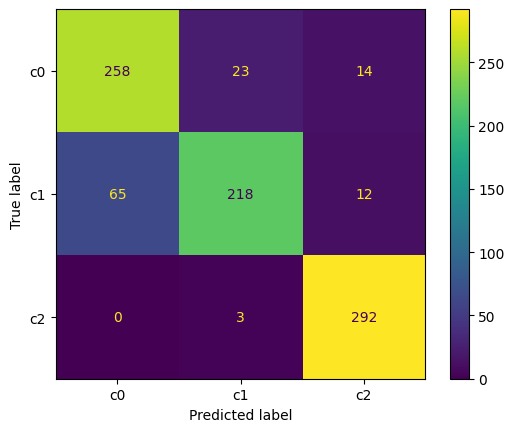

In [ ]:
#confusion matrix 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
val_generator.reset()
y_pred = model.predict(val_generator)
cm = confusion_matrix(val_generator.classes, y_pred.argmax(1))
ConfusionMatrixDisplay(cm, display_labels=list(train_generator.class_indices.keys())).plot()
plt.show()

In [15]:
tr_loss = history.history['loss']
tr_accuracy = history.history['accuracy']

val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

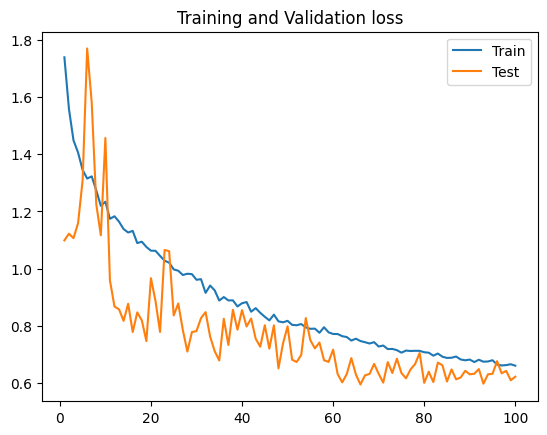

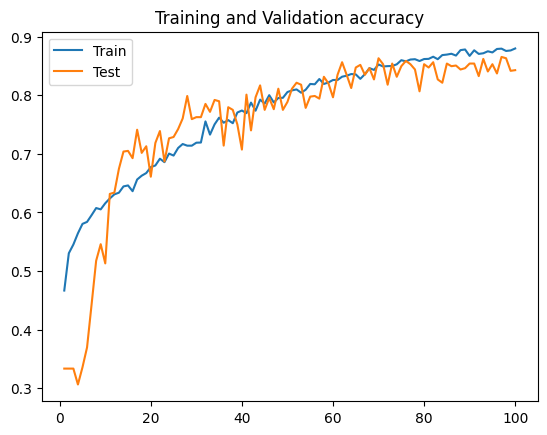

In [16]:
#graph training results
epchs = list(range(1,len(tr_loss)+1))
plt.plot(epchs,tr_loss,label='Train')
plt.plot(epchs,val_loss,label='Test')
plt.title("Training and Validation loss")
plt.legend()
plt.show()


plt.plot(epchs,tr_accuracy,label='Train')
plt.plot(epchs,val_accuracy,label='Test')
plt.title("Training and Validation accuracy")
plt.legend()
plt.show()

Saved predictions grid to predictions_grid.png


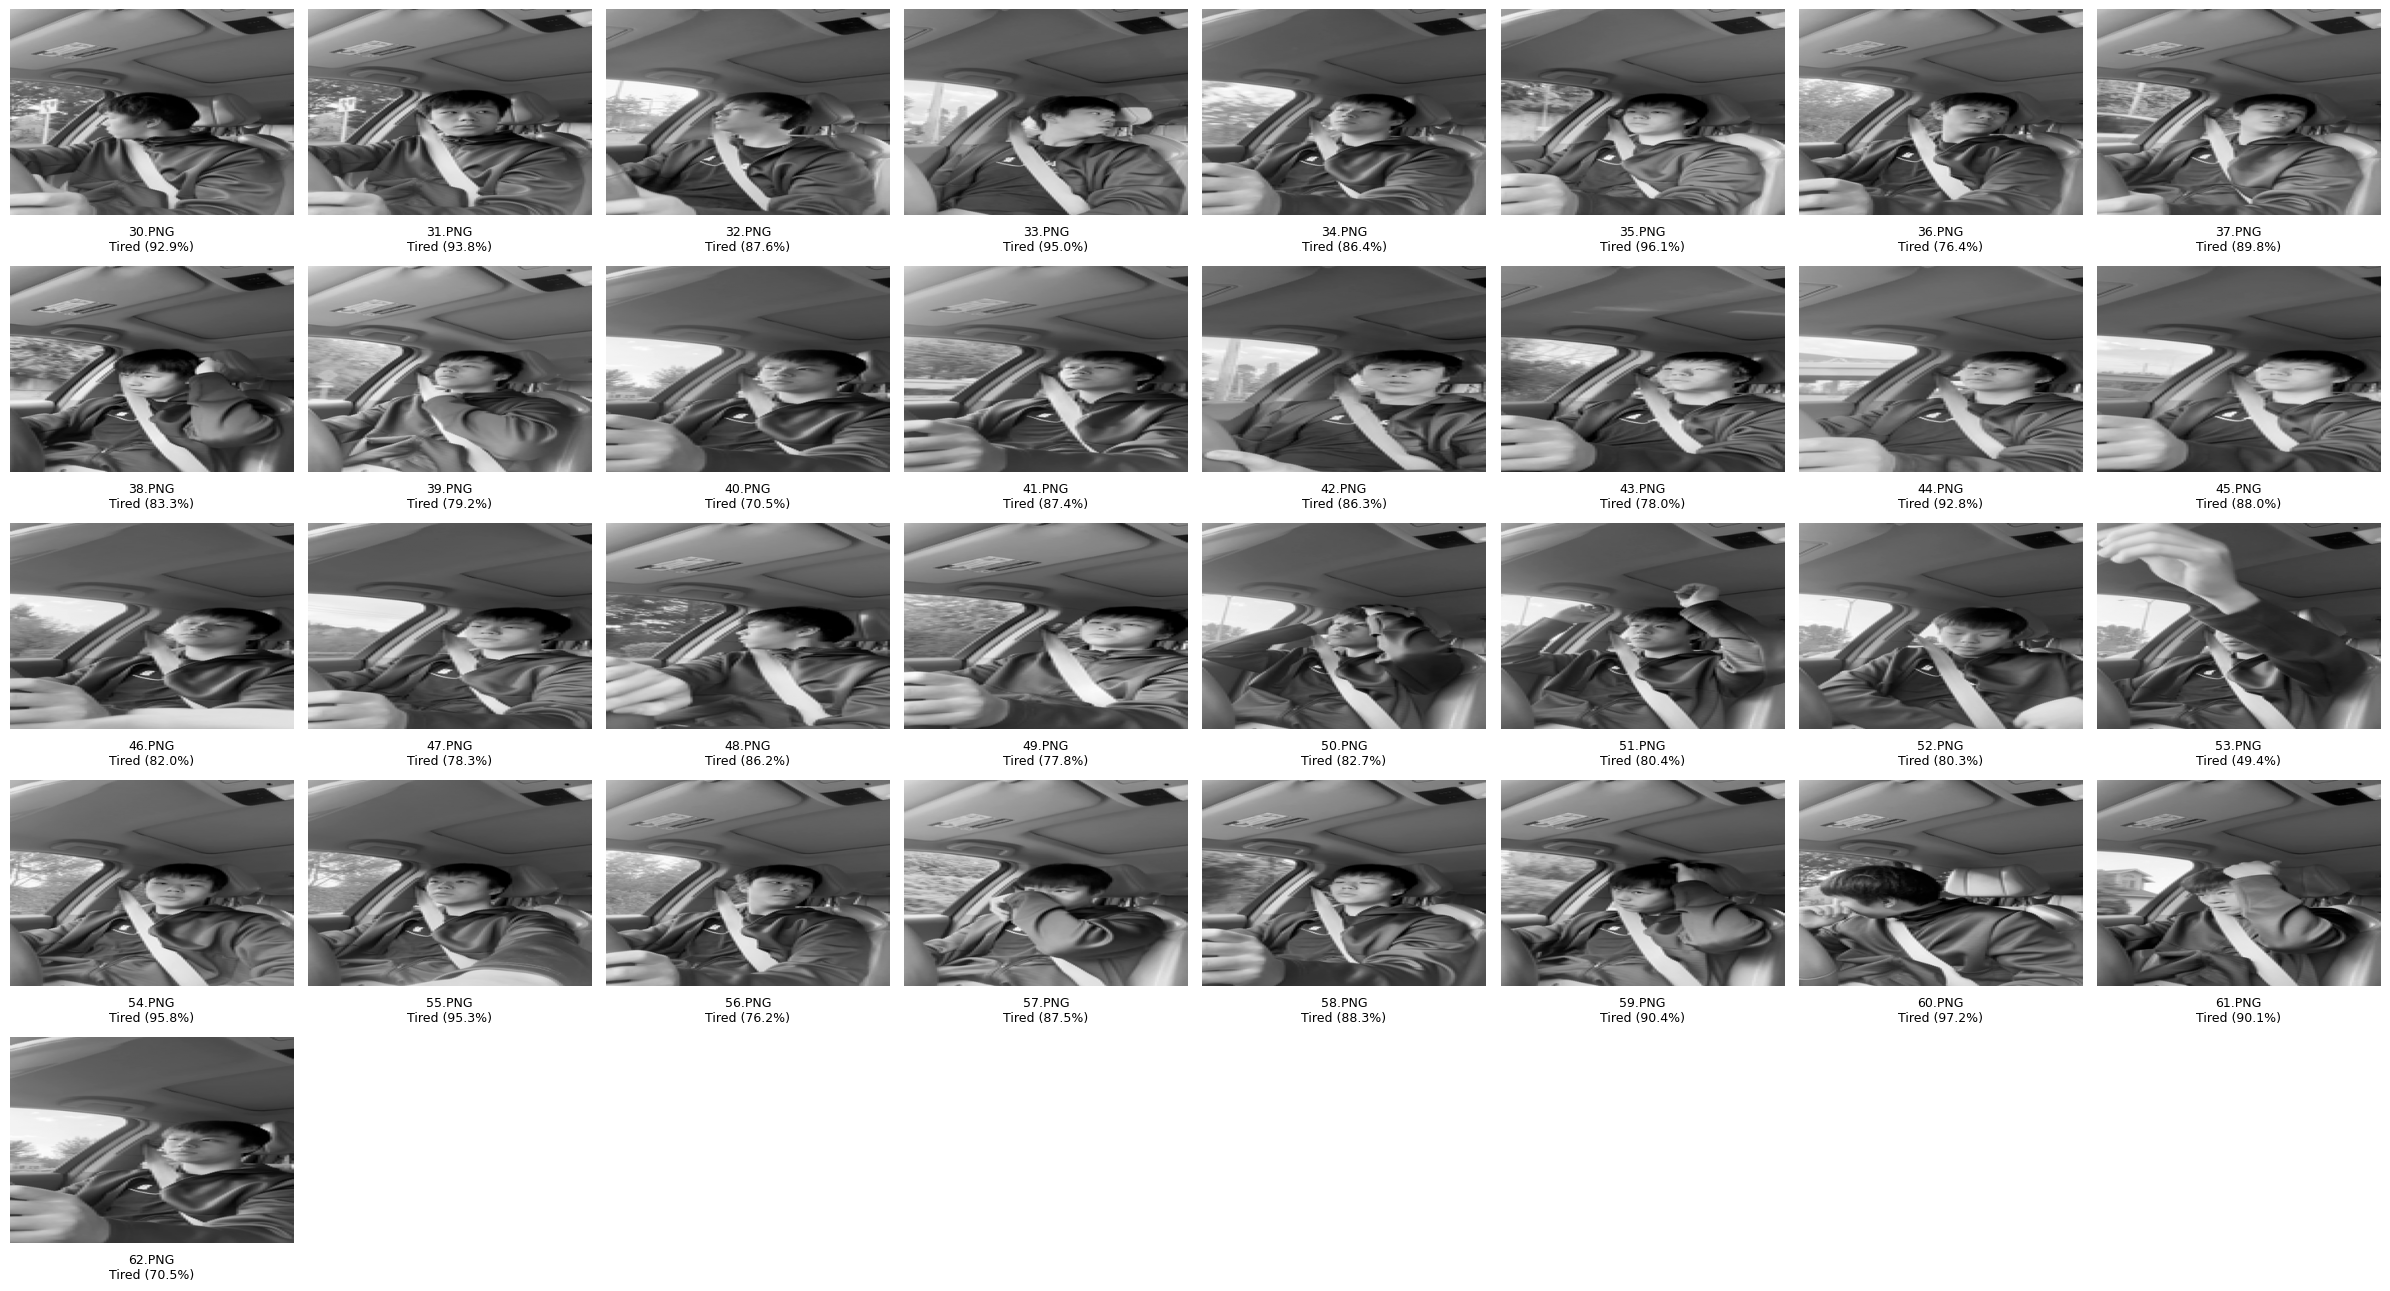

In [17]:
# test model with real data and show results
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dropout
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import os
import math

def to_rgb(x):
    return tf.image.grayscale_to_rgb(x)

model = load_model("distracted_driver_detection.keras",
    custom_objects={
        "CPUDropout": Dropout,
        "to_rgb": to_rgb
    })

class_names = ["Safe driving", "Distracted", "Tired"]

folder = "/home/lurpd/Development/Datasets/MyData/"
target_size=(MAX_SIZE, MAX_SIZE)

image_paths = []
for i in range(30, 63):
    for ext in [".png", ".PNG", ".jpg", ".JPG", ".jpeg", ".JPEG"]:
        candidate = os.path.join(folder, f"{i}{ext}")
        if os.path.exists(candidate):
            image_paths.append(candidate)
            break  

cols = 8
rows = math.ceil(len(image_paths) / cols)
max_width_px = 2500
max_height_px = 1300
dpi = 100
fig_width = min(max_width_px / dpi, cols * 3)
fig_height = min(max_height_px / dpi, rows * 3)
plt.figure(figsize=(fig_width, fig_height), dpi=dpi)

for idx, img_path in enumerate(image_paths):
    img = Image.open(img_path).convert("L")
    img.thumbnail((256, 256), Image.Resampling.LANCZOS)
    img_array = np.expand_dims(np.array(img).astype(np.float32) / 255.0, axis=(0, -1))

    predictions = model.predict(img_array, verbose=0)
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_label = class_names[predicted_class]
    confidence = np.max(predictions) * 100

    plt.subplot(rows, cols, idx + 1)
    plt.imshow(np.squeeze(img), cmap='gray', aspect='auto')
    plt.axis("off")
    plt.text(
        0.5, -0.05,
        f"{os.path.basename(img_path)}\n{predicted_label} ({confidence:.1f}%)",
        fontsize=9,
        ha="center", va="top",
        transform=plt.gca().transAxes
    )

plt.tight_layout()
plt.draw()

output_path = "predictions_grid.png"
plt.savefig(output_path, dpi=150, bbox_inches="tight")
print(f"Saved predictions grid to {output_path}")

try:
    if os.path.exists("/mnt/c/Windows"):
        os.system(f"explorer.exe {output_path.replace('/', '\\\\')}")
    else:
        os.system(f"xdg-open {output_path}")
except Exception as e:
    print(f"Could not auto-open image: {e}")
